# Workflow to compare TISSUES and NextProt data

### Import the required packages

In [1]:
## based on the tutorial https://jensenlab.org/training/stringapp/#exercise-3

import os
import sys
from time import sleep
import pandas as pd
import matplotlib
from py2cytoscape import cyrest
from IPython.display import Image
%matplotlib inline
from py2cytoscape.cyrest.base import api


### Setup Cytoscape
TODO: check if apps are installed and if not, install them

In [2]:
cytoscape=cyrest.cyclient()
cytoscape.version()

apiVersion v1
cytoscapeVersion 3.7.2


In [3]:
cytoscape.session.new()

### Protein network retrieval
Retrieve a STRING network for all UniProt identifiers in the table. 

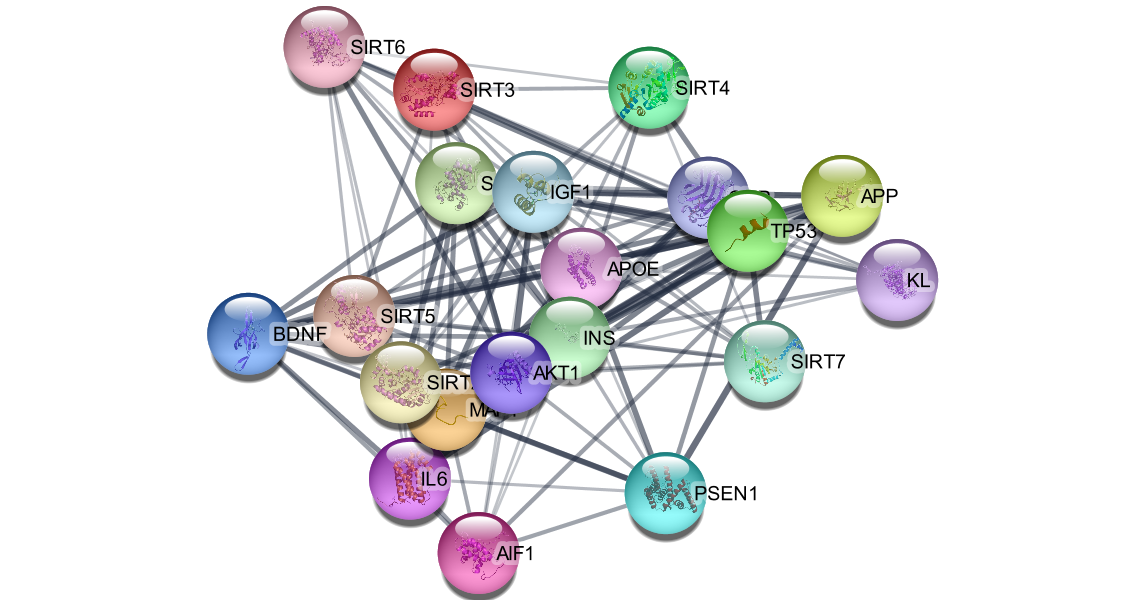

In [4]:
## create the string network with the uniprot ids
api(namespace="string",command="pubmed query",PARAMS={"cutoff": "0.4",
                                                      "limit": "20",
                                                      "pubmed": "aging",
                                                      "species": "homo sapiens",
                                                      "taxonID": "9606"})
sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

### Check for obsolete UniProt IDs

In [5]:
## get list 
uniprotIDs=list(set(cytoscape.table.getTable(columns=['stringdb::canonical name'],table='node')['stringdb::canonical name']))

### for python 2

In [ ]:
import urllib,urllib2
import pandas as pd

url = "https://www.uniprot.org/uploadlists/"
params = {
"from":"ACC",
"to":"ACC",
"format":"tab",
"query":" ".join(uniprotIDs)
}
data = urllib.urlencode(params)
request = urllib2.Request(url, data)
contact = "" # Please set a contact email address here to help us debug in case of problems (see https://www.uniprot.org/help/privacy).
request.add_header("User-Agent", "Python %s" % contact)
response = urllib2.urlopen(request)

### for python 3

In [6]:

## convert from STRING UniProt IDs to current IDs / check for obsolete IDs
import urllib.request, urllib.parse, urllib.error,urllib.request,urllib.error,urllib.parse
url = "https://www.uniprot.org/uploadlists/"
params = {
"from":"ACC",
"to":"ACC",
"format":"tab",
"query":" ".join(uniprotIDs)
}
data = urllib.parse.urlencode(params).encode("utf-8")
request = urllib.request.Request(url, data)
contact = "" # Please set a contact email address here to help us debug in case of problems (see https://www.uniprot.org/help/privacy).
request.add_header("User-Agent", "Python %s" % contact)
response = urllib.request.urlopen(request)

In [7]:
uniprot_mapping = pd.read_csv(response, sep ="\t")
nexProt_list=["entry:NX_"+each for each in uniprot_mapping['To']]
nexProt_list

['entry:NX_P49768',
 'entry:NX_Q8IXJ6',
 'entry:NX_Q9NTG7',
 'entry:NX_Q9UEF7',
 'entry:NX_Q96EB6',
 'entry:NX_P02649',
 'entry:NX_P31749',
 'entry:NX_P05019',
 'entry:NX_P01308',
 'entry:NX_P23560',
 'entry:NX_Q8N6T7',
 'entry:NX_P05231',
 'entry:NX_P04637',
 'entry:NX_Q9Y6E7',
 'entry:NX_P05067',
 'entry:NX_Q9NXA8',
 'entry:NX_P02741',
 'entry:NX_P55008',
 'entry:NX_P10636',
 'entry:NX_Q9NRC8']

### Get NextProt data
here we will retrieve the nextProt data from SparQL query.

In [8]:
a="""PREFIX : <http://nextprot.org/rdf#>
PREFIX entry: <http://nextprot.org/rdf/entry/>
PREFIX isoform: <http://nextprot.org/rdf/isoform/>
PREFIX annotation: <http://nextprot.org/rdf/annotation/>
PREFIX evidence: <http://nextprot.org/rdf/evidence/>
PREFIX xref: <http://nextprot.org/rdf/xref/>
PREFIX publication: <http://nextprot.org/rdf/publication/>
PREFIX identifier: <http://nextprot.org/rdf/identifier/>
PREFIX cv: <http://nextprot.org/rdf/terminology/>
PREFIX gene: <http://nextprot.org/rdf/gene/>
PREFIX source: <http://nextprot.org/rdf/source/>
PREFIX db: <http://nextprot.org/rdf/db/>
PREFIX context: <http://nextprot.org/rdf/context/>
PREFIX interaction: <http://nextprot.org/rdf/interaction/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>
PREFIX proteoform: <http://nextprot.org/rdf/proteoform/>
select distinct ?entry str(?gen) ?PAset (count(distinct(?pm)) as ?pepcnt) where {
values ?entry {"""

b=" ".join(nexProt_list)
c="""}
?entry :isoform ?iso .
  ?entry :gene / :name ?gen .
  ?iso :swissprotDisplayed true .   #restricts to canonical iso
  ?iso :peptideMapping ?pm .
  ?pm :proteotypic true .             #only uniquely mapping peptides
?pm :evidence / :assignedBy ?source .
    ?source rdfs:comment ?sourcename.
    bind(substr(str(?sourcename),48) as ?PAset)
  filter(regex(str(?sourcename),"PeptideAtlas"))   
  #filter (!regex(str(?sourcename), "Cancer"))   
  filter (!regex(str(?sourcename), "phosphoproteome")) 
  ?source rdfs:comment ?srcname.
  }
order by ?entry"""
query=a+b+c

### for python 2

In [ ]:
import urllib,urllib2
import pandas as pd

url = "https://sparql.nextprot.org/"

params = {
"query":query,
"format":"csv"
}

data = urllib.urlencode(params)
request = urllib2.Request(url, data)
contact = "" # Please set a contact email address here to help us debug in case of problems (see https://www.uniprot.org/help/privacy).
request.add_header("User-Agent", "Python %s" % contact)
response = urllib2.urlopen(request)



### for python 3

In [9]:
import urllib.request, urllib.parse, urllib.error,urllib.request,urllib.error,urllib.parse

import pandas as pd
from io import StringIO 

url = "https://sparql.nextprot.org/"

params = {
"query":query,
"format":"csv"
}

data = urllib.parse.urlencode(params).encode("utf-8")
request = urllib.request.Request(url, data)
contact = "" # Please set a contact email address here to help us debug in case of problems (see https://www.uniprot.org/help/privacy).
request.add_header("User-Agent", "Python %s" % contact)
response = urllib.request.urlopen(request)

In [10]:
nextProt_output = pd.read_csv(response, sep =",")
nextProt_output.head()

,entry,callret-1,PAset,pepcnt
0,http://nextprot.org/rdf/entry/NX_P01308,INS,Blood Plasma,3
1,http://nextprot.org/rdf/entry/NX_P01308,INS,Pancreas,5
2,http://nextprot.org/rdf/entry/NX_P01308,INS,Blood Cells,1
3,http://nextprot.org/rdf/entry/NX_P01308,INS,"Cancer, Pancreas",2
4,http://nextprot.org/rdf/entry/NX_P01308,INS,Non Cancer Cell Lines,2


## Convert NextProt data and merge with TISSUES
Create an OmicsVisualizer table

### process data from sparql query

In [11]:
#EXPECTS nextprot_output df

# unstack data to get tissues as separate columns
unstacked = nextProt_output.set_index(['entry','PAset'])[['pepcnt']].unstack()

# add gene names back to unstacked data
genes=nextProt_output.set_index('entry')['callret-1']
unstacked.reset_index(inplace=True)
mapped_genes=unstacked['entry'].map(genes.to_dict())
unstacked.insert(0,'gene',mapped_genes)
unstacked = unstacked.set_index("entry")

**process nextprot entry to get uniprot id**

In [12]:
def process_id(entry):
    return entry.strip().split('_')[-1]
unstacked.reset_index(inplace=True)
unstacked.insert(0,'uniprot_id',unstacked['entry'].apply(process_id))

**fill empty values with 0, assign proper column names**

In [13]:
result = unstacked.set_index('uniprot_id').fillna(0)
columns = list(result.columns.droplevel(level=0))
columns[0]='entry'
columns[1]='gene'
result.columns = columns

In [14]:
new_old_dict = uniprot_mapping.set_index('To')['From'].to_dict()

**map nextprot ids to old string ids**

In [15]:
result = result.reset_index()
result['uniprot_id'] = result['uniprot_id'].map(new_old_dict)
result.head()
result = result.set_index('uniprot_id')
result.head()

,entry,gene,Adrenal Gland,Alimentary System,Blood,Blood Cells,Blood Plasma,Brain,"Cancer Cell Lines, Alimentary System","Cancer Cell Lines, Brain",...,Pancreas,Pituitary Gland,Placenta,Sperm cell,Spleen,Testis,Thyroid,Ureter,Urinary Bladder,Urine
uniprot_id,,,,,,,,,,,,,,,,,,,,,
P01308,http://nextprot.org/rdf/entry/NX_P01308,INS,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
P02649,http://nextprot.org/rdf/entry/NX_P02649,APOE,23.0,30.0,22.0,95.0,186.0,38.0,12.0,4.0,...,24.0,34.0,29.0,25.0,35.0,69.0,32.0,15.0,19.0,35.0
P02741,http://nextprot.org/rdf/entry/NX_P02741,CRP,9.0,10.0,0.0,0.0,107.0,4.0,0.0,0.0,...,6.0,2.0,3.0,0.0,5.0,22.0,2.0,0.0,6.0,4.0
Q9NZD0,http://nextprot.org/rdf/entry/NX_P04637,TP53,0.0,0.0,13.0,1.0,1.0,0.0,20.0,23.0,...,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P05019,http://nextprot.org/rdf/entry/NX_P05019,IGF1,0.0,0.0,1.0,4.0,33.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Process node table

In [16]:
# EXPECTS nodes DATAFRAME
nodes = cytoscape.table.getTable(table='node', columns=['stringdb::canonical name','tissue::adrenal gland',
                                                'tissue::blood','tissue::bone','tissue::bone marrow','tissue::eye', 'tissue::gall bladder',
                                                'tissue::heart', 'tissue::intestine', 'tissue::kidney','tissue::liver','tissue::lung',
                                                'tissue::muscle','tissue::nervous system','tissue::pancreas','tissue::saliva',
                                                'tissue::skin', 'tissue::spleen', 'tissue::stomach','tissue::thyroid gland', 'tissue::urine'])

In [17]:
# find all tissues column in nodes table
nodes_tissues = [col for col in nodes.columns if 'tissue::' in col]
nodes = nodes.set_index('stringdb::canonical name')

# select tissue columns from node table
tissue_data = nodes.loc[:,nodes_tissues]
tissue_data.head()

,tissue::adrenal gland,tissue::blood,tissue::bone,tissue::bone marrow,tissue::eye,tissue::gall bladder,tissue::heart,tissue::intestine,tissue::kidney,tissue::liver,tissue::lung,tissue::muscle,tissue::nervous system,tissue::pancreas,tissue::saliva,tissue::skin,tissue::spleen,tissue::stomach,tissue::thyroid gland,tissue::urine
stringdb::canonical name,,,,,,,,,,,,,,,,,,,,
Q9NRC7,1.909443,4.513598,1.705926,2.295239,4.313832,1.198726,4.501164,2.529193,2.497317,4.530828,4.445986,2.593391,3.398537,2.303415,1.314798,2.589548,4.442934,2.127836,1.898793,1.408518
P55008,1.861096,4.622960,2.131281,1.956000,2.640023,0.566667,3.241816,2.313668,2.744439,4.549898,2.771242,2.409075,3.940674,1.601679,0.738918,2.662193,3.547017,1.170409,0.952890,1.142153
P02649,3.607068,4.721086,2.186999,3.019121,4.641532,2.683824,3.402483,3.433850,4.649531,4.912242,4.601307,3.472686,4.996425,2.870004,2.215358,4.829018,3.621384,2.786366,2.438450,2.098139
P05231,3.087821,3.890641,3.035168,3.685367,2.703898,2.679062,3.587524,3.715941,3.122689,3.622629,4.844492,3.468308,4.029044,3.075799,2.413838,3.189802,3.526279,2.508034,2.388187,2.731768
Q9UEF7,1.346994,2.298779,2.336787,1.477517,1.253504,1.603126,2.168036,2.197117,4.763373,2.107892,1.714083,2.267170,4.512114,1.792400,0.859053,1.696581,1.900460,1.194534,2.460189,2.260650


#### get tissue mapping between nextprot and tissuedb

In [18]:
# dictionary mapping nexprot tissues to TISSUESdb tissues
tissue_mapping = {
    'Adrenal Gland':'tissue::adrenal gland',
    'Blood Cells':'tissue::blood',
    'Blood Plasma':'tissue::blood',
    'Blood':'tissue::blood',
    'Eye':'tissue::eye',
    'Heart':'tissue::heart',
    'Kidney':'tissue::kidney',
    'Liver':'tissue::liver',
    'Lung':'tissue::lung',
    'Brain':'tissue::nervous system',
    'Cerebrospinal Fluid':'tissue::nervous system',
    'Olfactory System':'tissue::nervous system',
    'Pituitary Gland':'tissue::nervous system',
    'Pancreas':'tissue::pancreas',
    'Spleen':'tissue::spleen',
    'Thyroid':'tissue::thyroid gland',
    'Urinary Bladder':'tissue::urine',
    'Ureter':'tissue::urine',
    'Urine':'tissue::urine',
    'Alimentary System':'tissue::intestine',
}

In [19]:
# create dict with list of nextprot tissues belonging to each tissues tissue
tissues_to_np = {}

for key,value in tissue_mapping.items():
    if value in tissues_to_np.keys():
        tissues_to_np[value].append(key)
    else:
        tissues_to_np[value] = [key]

In [20]:
# stack tissues data into the required format
stacked_tissues = pd.DataFrame(tissue_data.stack())
stacked_tissues.columns=['tissues score']
stacked_tissues.head()

tissues score
stringdb::canonical name                                     
Q9NRC7                   tissue::adrenal gland       1.909443
                         tissue::blood               4.513598
                         tissue::bone                1.705926
                         tissue::bone marrow         2.295239
                         tissue::eye                 4.313832

### determine peptide evidence for each mapped tissue from nextprot

In [21]:
next_prot_bools = []

# go over all tissues in nodes data
for ttissue in nodes_tissues:
    # skip tissue if it doesnt map to nextprot
    if not ttissue in tissues_to_np.keys():
        continue
    # get nexprot tissues mapping to this tissue
    np_tissues = tissues_to_np[ttissue]
    # get peptide counts for all these tissues
    counts = result.loc[:,np_tissues]
    # boolean for peptide presence or absence
    summed = counts.sum(axis=1)
    bools = pd.DataFrame(summed!= 0)
    bools.columns = [ttissue]
    # add dataframe to list
    next_prot_bools.append(bools)
    
# concatenate the dataframes with nextprot boolean arrays
nextprot_result = pd.concat(next_prot_bools, axis =1) 

# stack the datataframe to be in the 
# same format as the stacked tissues data
nextprot_stacked = pd.DataFrame(nextprot_result.stack())
nextprot_stacked.reset_index(inplace=True)
nextprot_stacked.columns = ['uniprot_id','tissue','np']
nextprot_stacked.head()

,uniprot_id,tissue,np
0,P01308,tissue::adrenal gland,False
1,P01308,tissue::blood,True
2,P01308,tissue::eye,False
3,P01308,tissue::heart,False
4,P01308,tissue::intestine,False


#### merge stacked tissues and stacked nextprot dataframes

In [22]:
merged_data = stacked_tissues.merge(
    nextprot_stacked,
    how='inner',
    left_index=True,
    right_on=['uniprot_id','tissue'])
merged_data = merged_data[['uniprot_id','tissue','tissues score','np']]

# strip the '::tissue' part from the tissue names
def strip_tissue(value):
    return value.split('::')[-1]
merged_data['tissue'] = merged_data['tissue'].apply(strip_tissue)
merged_data.head()


,uniprot_id,tissue,tissues score,np
169,Q9NRC7,adrenal gland,1.909443,False
170,Q9NRC7,blood,4.513598,True
171,Q9NRC7,eye,4.313832,False
172,Q9NRC7,heart,4.501164,True
173,Q9NRC7,intestine,2.529193,True


In [23]:
merged_data.to_csv(
    'stacked_tissues_nextprot.tsv',
    index=False,
    sep='\t')

# omics visualizer

## load merged nextProt and Tissues database data into omics visualizer

In [29]:
fileName="stacked_tissues_nextprot.tsv"
api(namespace='ov',command='load',
    PARAMS ={
     "file": fileName,
    "keyColumnIndex": "1",
    "startLoadRow":'1',
    "dataTypeList":"s,s,d,b",
    "newTableName":'test'
    }
)


### now connect this table to the string network with the key

In [34]:
api(namespace='ov',command='connect', PARAMS ={
    'mappingColNet':'stringdb::canonical name',
    'mappingColTable':'uniprot_id',
    }
)

## now do visualization with omics visualizer

### 1. create the pie chart with the nextProt boolean data

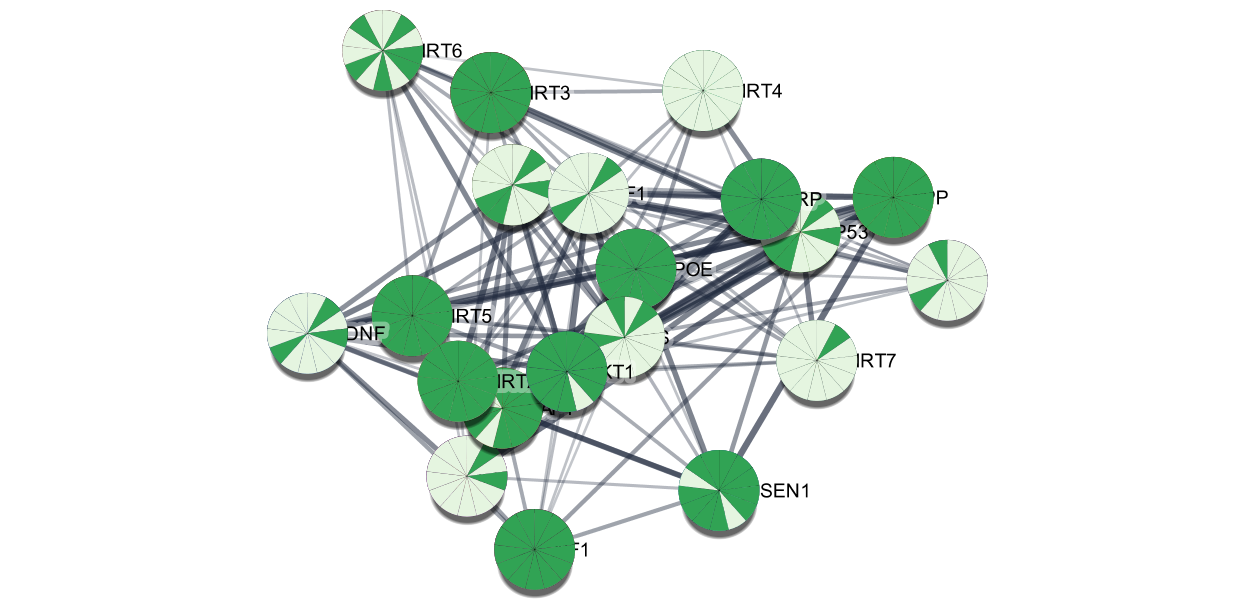

In [37]:
api(namespace='ov',command='viz apply inner discrete', PARAMS ={
    'attributes':'np',
    'colorMapping':'A:white,B:green',
    'paletteName':'Green Shades',
    'paletteProviderName':'ColorBrewer'
    }
)

sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

### 2. then create the donut chart visualization with Tissues database, using database score

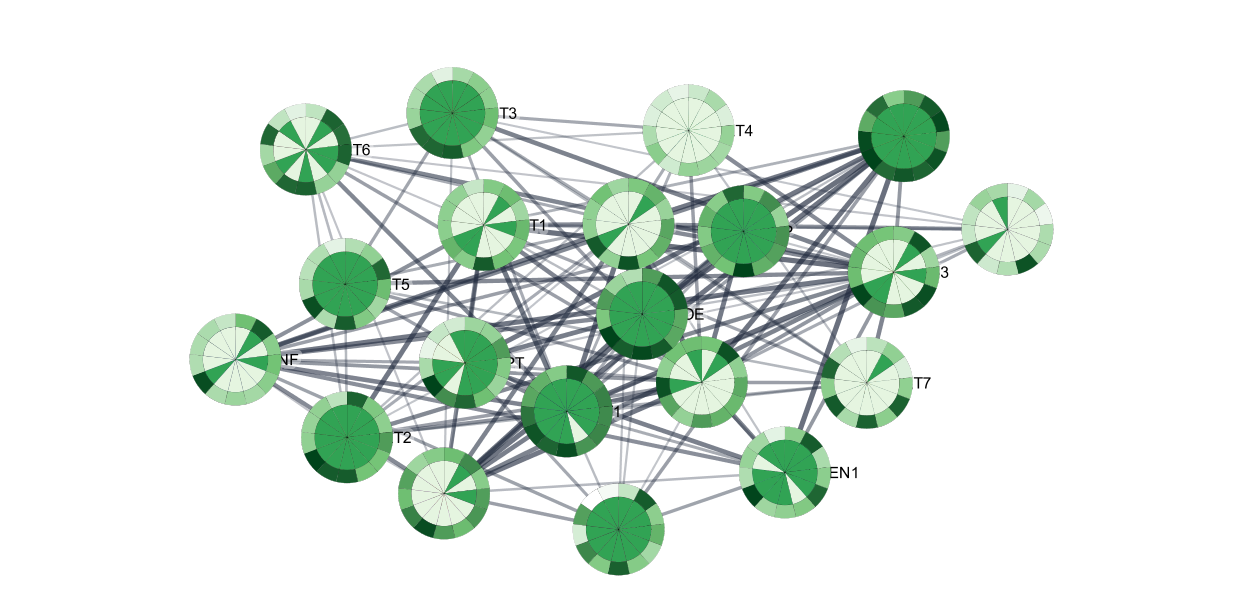

In [44]:

api(namespace='ov',command='viz apply outer continuous', PARAMS ={
    'attributes':'tissues score',
    'colorMax':'dark green',
    'colorMid':'light green',
    'colorMin':'white',
    'paletteName':'Green Shades',
    'paletteProviderName':'ColorBrewer',
    'rangeMax':'5',
    'rangeMid':'3',
    'rangeMin':'1'
    }
)

sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

## Save the session

In [45]:
cytoscape.session.save_as(session_file="tissues_nextprot_merge")